In [ ]:
%load_ext autoreload
%autoreload 2
import sys, os
import pandas as pd
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d as interp
from datetime import datetime
from matplotlib import colormaps as cm
from matplotlib import patches, lines
sys.path.append('../src/')
from Biologging_Toolkit.applications.Wind_Direction import WindDirection
from Biologging_Toolkit.utils.inertial_utils import *
plt.rcParams.update({
    "text.usetex": True,                # Enable LaTeX text rendering
    "font.family": "serif",             # Use a serif font
    "font.serif": ["Computer Modern"],  # Set font to Computer Modern (LaTeX default)
})

In [15]:
depids = ['ml17_280a','ml18_296a','ml18_294b','ml19_292a','ml19_292b','ml19_293a','ml19_294a','ml20_293a','ml20_296b','ml20_313a','ml21_295a','ml21_305b']
mls = os.listdir('D:/individus_brut/CTD/')[:-1]
depid = depids[8]
path = f'D:/individus_brut/individus/{depid}/'

In [ ]:
measurements = pd.read_csv('D:/individus_brut/measurements_eleph.csv')
fig, ax = plt.subplots(1,2, figsize = (13,6), sharey = True)
ax[0].set_xlabel('Weight (kg)')
ax[1].set_xlabel('Total length (cm)')
ax[0].set_ylabel('Positive angular correlation')
ax[0].set_ylim(0,1)
res = {}
for ml in mls :
    try :
        weight = measurements.poids[measurements.dataset == ml]
        size = measurements.taille[measurements.dataset == ml]
        inst = WindDirection(ml, path = os.path.join('D:/individus_brut/CTD/',ml))
        inst.get_average_posture()
        #inst.filter_wind_speed(threshold = 17)
        #inst.get_correlation(filtered = True)
        #ax[0].scatter(weight, inst.positive_corr, c = 'b')
        #ax[0].scatter(weight, inst.negative_corr, c = 'orange')
        #ax[1].scatter(size, inst.positive_corr, c = 'b')
        inst.get_correlation()
        ax[0].scatter(weight, inst.positive_corr, c = 'r')
        ax[1].scatter(size, inst.positive_corr, c = 'r')
        #ax[1].scatter(size, inst.negative_corr, c = 'orange')
        _results = []
        for i in [0, 2, 5, 7, 10, 12, 15, 17, 20, 23] :
            inst.filter_wind_speed(threshold = i)
            inst.get_correlation(filtered = True)
            _results.append(inst.positive_corr)
        res[ml] = _results
    except :
        continue

In [ ]:
fig.tight_layout()
fig.savefig('C:/Users/grosm/Desktop/thèse/Results/weight_correlation.pdf')

In [ ]:
a = [[],[],[],[],[],[],[], [], [], []]
for key in res.keys():
    for i in range(len(res[key])) :
        a[i].extend([res[key][i]])

In [ ]:
b = []
for i in range(len(a)):
    b.append(np.nanmean(a[i]))


In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
wind = [0, 2, 5, 7, 10, 12, 15, 17, 20, 23]
for i in range(len(b)) :
    ax.scatter(wind[i], b[i], c = 'k')
ax.grid()
ax.set_ylabel('Positive angular correlation')
ax.set_xlabel('Minimum wind speed (m/s)')
ax.set_ylim(0,1.02)

In [ ]:
fig.savefig('C:/Users/grosm/Desktop/thèse/Results/correlation_wind.pdf')

In [ ]:
ds = nc.Dataset(os.path.join('D:/individus_brut/CTD/',ml,f'{ml}.nc'))

In [ ]:
nc.Dataset(os.path.join('D:/individus_brut/CTD/',ml,f'{ml}trk.nc'))['POS']

In [ ]:
depids

In [ ]:
depid = depids[4]
path = f'D:/individus_brut/individus/{depid}/'

In [ ]:
ds

In [ ]:
inst.ds

In [31]:
depid = depids[3]
path = f'D:/individus_brut/individus/{depid}/'

In [47]:
depid

'ml19_292a'

In [32]:
inst = WindDirection(depid, path = path)
aux = pd.read_csv(os.path.join(path, f'aux_data.csv'))

C:\Users\grosmaan\Desktop\Biologging_Toolkit\notebooks\../src\Biologging_Toolkit\utils\inertial_utils.py:26: RuntimeWarning: invalid value encountered in scalar divide
  x_mean = np.nansum(x_coords) / len(angles)
C:\Users\grosmaan\Desktop\Biologging_Toolkit\notebooks\../src\Biologging_Toolkit\utils\inertial_utils.py:27: RuntimeWarning: invalid value encountered in scalar divide
  y_mean = np.nansum(y_coords) / len(angles)
C:\Users\grosmaan\AppData\Local\Temp\ipykernel_41980\3131569425.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


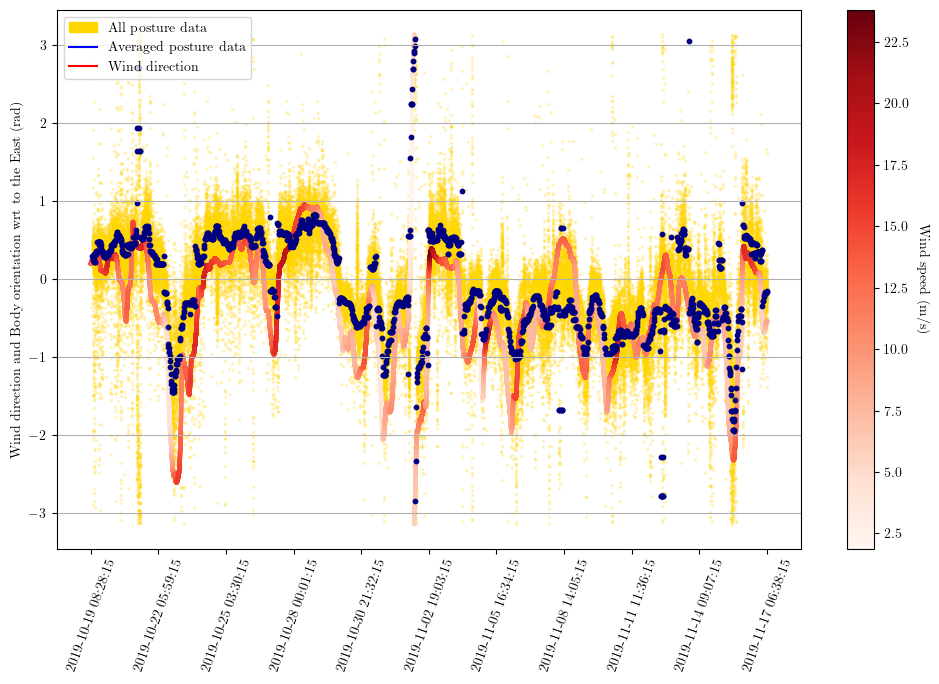

In [45]:
#Get azimuth as a function of elevation angle
orientation = inst.ds['azimuth'][:].data
orientation[inst.ds['elevation_angle'][:].data > 1.40] = inst.ds['vertical_azimuth'][:].data[inst.ds['elevation_angle'][:].data > 1.40]
t_off = 10*60
graph = True
corr = False
plot_errors = False

#Get surface times with dives longer than t_off
time_data = inst.ds['time'][:].data[inst.ds['depth'][:].data < 1]
pos_dt = time_data[1:]-time_data[:-1]
dives = np.where((pos_dt > t_off))[0]
upper_bound, lower_bound = time_data[dives][1:], time_data[dives+1][:-1]
avg_rot, avg_time, _rot, _time, len_rot = [], [], [], [], []

fig1, ax1 = plt.subplots(figsize=(12,7))

#Get orientation data for those dives (remove beginning and end of surfacing)
for time_up, time_down in zip(upper_bound, lower_bound) :
    len_rot.append(abs(time_up - time_down))
    rot_data = modulo_pi(orientation[(inst.ds['time'][:].data < time_up) & (inst.ds['time'][:].data > time_down)] + np.pi/2 + 3)
    if graph :
        ax1.scatter(inst.ds['time'][:].data[(inst.ds['time'][:].data < time_up) & (inst.ds['time'][:].data > time_down)],
                    rot_data, color='gold',s=2, alpha = 0.2)
    _rot.append(angular_average(rot_data[5:-5]))
    _time.append(np.nanmean([time_up, time_down]))
#Rolling average of surface orientations
orientation_conv = pd.Series(_rot).rolling(window = 15, min_periods = 5, center = True).median().to_numpy()

if graph :
    cmap = cm.get_cmap('Reds')
    sc = ax1.scatter(aux.time, modulo_pi(np.arctan2(aux.v10, aux.u10)), c = np.sqrt(aux.u10**2 + aux.v10**2),
                s = 5, cmap = cmap, label='wind direction')
    '''plt.scatter(aux.time, modulo_pi(aux.mdts*np.pi/180+np.pi/2), label='Direction swell',s=2)
    plt.scatter(aux.time, modulo_pi(aux.mdww*np.pi/180+np.pi/2), label='Direction wind waves',s=2)
    plt.scatter(aux.time, modulo_pi(aux.mwd*np.pi/180+np.pi/2), label='Direction wave',s=2)
    plt.scatter(aux.time, modulo_pi(aux.dwi*np.pi/180+np.pi/2), label='Direction wave',s=2)'''
    ax1.scatter(_time, modulo_pi(orientation_conv), label = 'Averaged posture', c = 'navy', s = 10)
    ax1.grid(axis = 'y')
    ax1.set_xticks(ticks = aux.time[::len(aux.time)//10])
    ax1.set_xticklabels([datetime.fromtimestamp(ts) for ts in aux.time[::len(aux.time)//10]], rotation = 70)
    ax1.set_ylabel('Wind direction and Body orientation wrt to the East (rad)')
    # Creating custom legend handles
    gold_scatter = patches.Patch(color='gold', label='All posture data')
    blue_line = lines.Line2D([], [], color='blue', label='Averaged posture data')
    red_line = lines.Line2D([], [], color='red', label='Wind direction')
    ax1.legend(handles=[gold_scatter, blue_line, red_line])
    cbar = fig1.colorbar(sc, ax=ax1)
    cbar.set_label('Wind speed (m/s)', rotation=270, labelpad=15)
    fig1.show()

if corr :
    #Correlation
    wind_orientation = interp(aux.time, np.arctan2(aux.v10, aux.u10), bounds_error = False)(_time)
    y1 = interp(aux.time, modulo_pi(aux.mdts*np.pi/180+np.pi/2), bounds_error = False)(_time)
    y2 = interp(aux.time, modulo_pi(aux.mdww*np.pi/180+np.pi/2), bounds_error = False)(_time)
    y3 = interp(aux.time, modulo_pi(aux.mwd*np.pi/180+np.pi/2), bounds_error = False)(_time)
    y4 = interp(aux.time, modulo_pi(aux.dwi*np.pi/180+np.pi/2), bounds_error = False)(_time)
    corr = []

    for env_var in (wind_orientation,y1,y2,y3,y4):
        corr.append(angular_correlation(orientation_conv, env_var))
    corr_df = pd.DataFrame(corr, columns = ['positive','negative'])
    corr_df['var'] = ['wind direction', 'mdts', 'mdww', 'mwd', 'dwi']

if plot_errors :
    cmap = cm.get_cmap('Reds')
    az = modulo_pi(interp(aux.time, aux.sun_azimuth, bounds_error = False)(_time))
    zen = interp(aux.time, aux.sun_zenith, bounds_error = False)(_time)
    wind_dir = modulo_pi(interp(aux.time, np.arctan2(aux.v10, aux.u10), bounds_error=False)(_time))
    y1 = interp(aux.time, np.sqrt(aux.u10**2 + aux.v10**2), bounds_error = False)(_time)
    y2 = interp(aux.time, modulo_pi(aux.mdww*np.pi/180+np.pi/2), bounds_error = False)(_time)
    y3 = interp(aux.time, modulo_pi(aux.mwd*np.pi/180+np.pi/2), bounds_error = False)(_time)
    y4 = interp(aux.time, modulo_pi(aux.dwi*np.pi/180+np.pi/2), bounds_error = False)(_time)

    azimuth = abs(modulo_pi(az+np.pi-wind_dir))

    err = abs(modulo_pi(wind_dir - orientation_conv))
    fig, ax = plt.subplots(1,3, figsize = (15, 7))
    ax = ax.flatten()
    ax[0].scatter(azimuth, err)
    ax[1].scatter(zen, err)
    ax[2].scatter(y1, err)

plt.show()

In [46]:
fig1.tight_layout()
fig1.savefig('C:/Users/grosmaan/Desktop/Results/wind_direction_2.pdf')